### Loading Cleaned Metadata files

In [330]:
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt

import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torch import tensor

import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
# from torchvision.transforms import ToTensor
from torch import nn, optim
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
#from torchmetrics.classification import MulticlassF1Score
#from torchmetrics.classification import MulticlassPrecisionRecallCurve, MultilabelPrecisionRecallCurve, PrecisionRecallCurve
from torcheval.metrics.functional import multiclass_precision, multiclass_f1_score, multiclass_recall, multiclass_accuracy


import cv2
from PIL import Image
from transformers import ViTModel, ViTImageProcessor, ViTForImageClassification
from timm import create_model

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import WeightedRandomSampler

#from torchsampler import ImbalancedDatasetSampler

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where
import shutil
from torch import tensor

In [2]:
print("Current Path : ", os.getcwd())
os.chdir('../..')

Current Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/src/04_models


In [3]:
ROOT_DIR = os.getcwd()
print("Root Project Path : ", ROOT_DIR)
ROOT_DATA_DIR = os.path.join(ROOT_DIR, 'data', 'xview_building_damage')
print("Root Data Path : ", ROOT_DATA_DIR)
TRAIN_DATA_DIR = os.path.join(ROOT_DATA_DIR, 'train')
print("Train Data Path : ", TRAIN_DATA_DIR)
CHALLENGE_DIR = os.path.join(ROOT_DATA_DIR, 'challenge')
TRAIN_DIR=os.path.join(CHALLENGE_DIR, 'train')
HOLD_DIR=os.path.join(CHALLENGE_DIR, 'hold')
TEST_DIR=os.path.join(CHALLENGE_DIR, 'test')

Root Project Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio
Root Data Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage
Train Data Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/train


### Custom Dataset class

In [4]:
train_meta_df=pd.read_csv(os.path.join(ROOT_DATA_DIR, 'challenge', 'csv', 'hc_train_hurricane-michael.csv'))
valid_meta_df=pd.read_csv(os.path.join(ROOT_DATA_DIR, 'challenge', 'csv', 'hc_hold_hurricane-michael.csv'))
test_meta_df=pd.read_csv(os.path.join(ROOT_DATA_DIR, 'challenge', 'csv' , 'hc_test_hurricane-michael.csv'))

### Setting the device

In [5]:
model_name = "vit_base_patch16_224"
device = 'cpu' 
if torch.cuda.is_available(): 
 device='cuda'
elif torch.backends.mps.is_available():
 device = 'mps' 

print("device = ", device)

device =  mps


### Helper Methods

In [175]:
def polygons_mask(polygons, im_size):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

In [179]:
polygons_mask([shapely.wkt.loads(train_meta_df.iloc[0]['image_polygon'])],image.shape[:2])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

(1024, 1024)


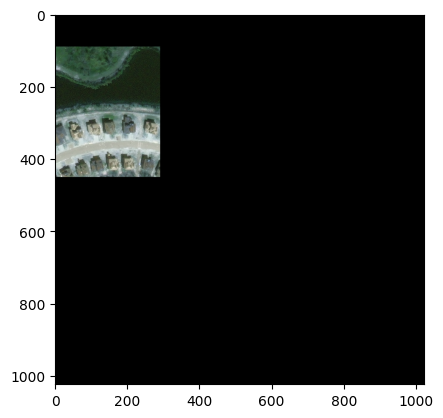

In [150]:
dir_test =  os.path.join(ROOT_DATA_DIR, 'challenge', 'train', 'disaster', 'hurricane-michael')
image = cv2.imread(os.path.join(dir_test, 'hurricane-michael_00000000_post_disaster.png'))
cv2.imshow("Original", image)

mask = np.zeros(image.shape[:2], dtype="uint8")

cv2.rectangle(mask, (0, 90), (290, 450), 255, -1)
cv2.imshow("Rectangular Mask", mask)

masked = cv2.bitwise_and(image, image, mask=mask)
#cv2.imshow("Mask Applied to Image", masked)
# cv2.waitKey(0)
plt.imshow(masked)
#plt.savefig(masked)
plt.imsave(os.path.join(dir_test, 'masked.png'), masked)


In [197]:
train_data = train_meta_df[train_meta_df['damage'] != 'un-classified']
train_data_wo_pre = train_data[train_data['damage'] != 'pre']
train_data_wo_pre['damage'].value_counts()

damage
no-damage       14588
minor-damage     5207
major-damage     1902
destroyed         757
Name: count, dtype: int64

In [355]:
train_data_wo_pre.to_csv(os.path.join(ROOT_DATA_DIR, 'challenge', 'csv')+"/train_4_classes_post_micheal.csv")

In [228]:
valid_data = valid_meta_df[valid_meta_df['damage'] != 'un-classified']
valid_data_wo_pre = valid_data[valid_data['damage'] != 'pre']
valid_data_wo_pre['damage'].value_counts()

damage
no-damage       4457
minor-damage    1722
major-damage     608
destroyed        285
Name: count, dtype: int64

In [356]:
valid_data_wo_pre.to_csv(os.path.join(ROOT_DATA_DIR, 'challenge', 'csv')+"/hold_4_classes_post_micheal.csv")

In [233]:
valid_data_wo_pre['height'].value_counts()

height
1024    7072
Name: count, dtype: int64

In [231]:
test_data = test_meta_df[test_meta_df['damage'] != 'un-classified']
test_data_wo_pre = test_data[test_data['damage'] != 'pre']
test_data_wo_pre['damage'].value_counts()

damage
no-damage       3647
minor-damage    1363
major-damage     409
destroyed        183
Name: count, dtype: int64

In [357]:
test_data_wo_pre.to_csv(os.path.join(ROOT_DATA_DIR, 'challenge', 'csv')+"/test_4_classes_post_micheal.csv")

In [226]:
def polygons_mask(polygons):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask



def create_image_mask_overall(root_dir, im_size, meta_df ,dataSplit = 'train', disaster_name='hurricane-michael'):
   input_dir =  os.path.join(root_dir, 'challenge', dataSplit, 'disaster', disaster_name) 
   img_input = os.path.join(input_dir, 'images')
   output_dir =os.path.join(input_dir, 'img_mask_overlay')

   df = meta_df[meta_df['is_post_image'] == True]
   print("Starting : Mask overlay")
   for idx, file_name in enumerate(df['mask_file_names']):
       image = cv2.imread(os.path.join(img_input, df.iloc[idx]['img_name']))
       mask = np.zeros(image.shape[:2], dtype="uint8")
       _mask = polygons_mask([shapely.wkt.loads(df.iloc[idx]['image_polygon'])])
       masked = cv2.bitwise_and(image, image, mask=_mask)
       plt.imsave(os.path.join(output_dir, file_name), masked)
   print("Ending : Mask overlay")

In [227]:
im_size =(1024, 1024)
create_image_mask_overall(ROOT_DATA_DIR, im_size, train_data_wo_pre, 'train', 'hurricane-michael')

Starting : Mask overlay
Ending : Mask overlay


In [235]:
create_image_mask_overall(ROOT_DATA_DIR, im_size, valid_data_wo_pre, 'hold', 'hurricane-michael')

Starting : Mask overlay
Ending : Mask overlay


In [237]:
create_image_mask_overall(ROOT_DATA_DIR, im_size, test_data_wo_pre, 'test', 'hurricane-michael')

Starting : Mask overlay
Ending : Mask overlay


In [ ]:
/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge

In [239]:
def sort_masks_by_class(top_dir, meta_df, disaster_name='hurricane-michael', post=True):
    root_path=os.path.join(top_dir, 'disaster', disaster_name)
    disas_post_mask= os.path.join(root_path,'img_mask_overlay') #source
    print("Source root : ", disas_post_mask)
    disas_class_path=os.path.join(root_path, 'img_mask_ov_class')
    print("Destination root : ", disas_class_path)
    
    df = meta_df[meta_df['is_post_image'] == True]
    
    #    df = meta_df[meta_df['is_pre_image'] != post]
    print("Started moving the mask files to class folder for ", disaster_name)
    for idx, file_name in enumerate(df['mask_file_names']):
        source = os.path.join(disas_post_mask, df.iloc[idx]['mask_file_names'])
        destination = os.path.join(disas_class_path, df.iloc[idx]['damage'])
        if os.path.exists(destination):
            pass
        else:
            print( "Creating dir for " , df.iloc[idx]['damage'])
            os.mkdir(destination)
        
        if os.path.exists(source):
            shutil.copy(source, destination)
    print("Finshed moving the mask files to class folder for ", disaster_name)

In [241]:
sort_masks_by_class(TRAIN_DIR , train_data_wo_pre , 'hurricane-michael')

Source root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/train/disaster/hurricane-michael/img_mask_overlay
Destination root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/train/disaster/hurricane-michael/img_mask_ov_class
Started moving the mask files to class folder for  hurricane-michael
Finshed moving the mask files to class folder for  hurricane-michael


In [242]:
sort_masks_by_class(HOLD_DIR , valid_data_wo_pre , 'hurricane-michael')

Source root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/hold/disaster/hurricane-michael/img_mask_overlay
Destination root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/hold/disaster/hurricane-michael/img_mask_ov_class
Started moving the mask files to class folder for  hurricane-michael
Finshed moving the mask files to class folder for  hurricane-michael


In [243]:
sort_masks_by_class(TEST_DIR , test_data_wo_pre , 'hurricane-michael')

Source root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/test/disaster/hurricane-michael/img_mask_overlay
Destination root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/test/disaster/hurricane-michael/img_mask_ov_class
Started moving the mask files to class folder for  hurricane-michael
Finshed moving the mask files to class folder for  hurricane-michael


In [117]:
def get_overlapped_img():#filename, img_folder, mask_folder):
    # Import orginal img
    dir_test =  os.path.join(ROOT_DATA_DIR, 'challenge', 'train', 'disaster', 'hurricane-michael')
    mask='hurricane-michael_00000000_post_disaster_0aa410ed-e9af-4ae0-b639-d9e70fc7be80.png'
    image = 'hurricane-michael_00000000_post_disaster.png'
    img = cv2.imread(os.path.join(dir_test, image))

    # Import and convert the mask from binary to RGB
    mask = Image.open(os.path.join(dir_test, mask))#.convert('RGB')
    width, height = mask.size

    # Convert the white color (for blobs) to magenta
    mask_colored = change_color(mask, width, height, (255, 255, 255), (186,85,211))
    #mask_colored = change_color(mask, width, height, (0, 0, 0), (255,255,255))
    # Convert the black (for background) to white --> important to make a good overlapping
    mask_colored = change_color(mask_colored, width, height,(255,255,255), (0, 0, 0))

    return cv2.addWeighted(np.array(img),0.4,np.array(mask_colored),0.3,0)

In [104]:
def change_color(picture, width, height, ex_color, new_color):
    # Process every pixel
    for x in range(width):
        for y in range(height):
            current_color = picture.getpixel( (x,y) )
            if current_color == ex_color:
                picture.putpixel( (x,y), new_color)
    return picture

In [119]:
get_overlapped_img()

array([[[ 7, 12,  9],
        [ 6, 10,  8],
        [ 7, 12,  9],
        ...,
        [26, 36, 32],
        [24, 35, 30],
        [24, 36, 30]],

       [[ 9, 15, 12],
        [ 8, 14, 11],
        [ 8, 13, 10],
        ...,
        [23, 34, 29],
        [23, 33, 28],
        [24, 35, 29]],

       [[13, 22, 18],
        [10, 16, 13],
        [ 8, 13, 10],
        ...,
        [28, 40, 34],
        [28, 40, 34],
        [24, 36, 30]],

       ...,

       [[58, 64, 64],
        [64, 70, 70],
        [68, 74, 75],
        ...,
        [24, 33, 28],
        [26, 36, 30],
        [27, 38, 32]],

       [[57, 64, 64],
        [63, 69, 70],
        [68, 74, 74],
        ...,
        [24, 33, 28],
        [26, 36, 30],
        [31, 42, 36]],

       [[60, 67, 68],
        [67, 72, 74],
        [76, 81, 82],
        ...,
        [23, 32, 26],
        [26, 35, 29],
        [31, 42, 36]]], dtype=uint8)

#### Data Augumentation:

In [6]:
# Write transform for image

data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    #transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [88]:
alb_data_transform =  A.Compose([
    A.CLAHE(p=0.5),
    A.RandomCrop(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.Flip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
    A.RandomCrop(height=256, width=256),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
    ToTensorV2()
])

#### Load & Prepare Data

In [358]:
def get_img_class_dir(disaster_name, dataSplit, ROOT_DIR, class_dir='img_mask_ov_class'):   
 #DIR=os.path.join(ROOT_DIR, dataSplit,'disaster', disaster_name , 'class', 'post')
 root_path=os.path.join(ROOT_DIR, 'disaster', disaster_name)
 DIR = os.path.join(root_path, class_dir)
 return DIR

In [250]:
train_dataset = datasets.ImageFolder(get_img_class_dir('hurricane-michael', 'train', TRAIN_DIR), transform=data_transform)
valid_dataset = datasets.ImageFolder(get_img_class_dir('hurricane-michael', 'hold', HOLD_DIR), transform=data_transform)
test_dataset = datasets.ImageFolder(get_img_class_dir('hurricane-michael', 'test', TEST_DIR), transform=data_transform)
#dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
print("Train set records : ", len(train_dataset))
print("Validation set records : ", len(valid_dataset))
print("Test set records : ", len(test_dataset))
print("================================================")
print(f"Train data:\n{train_dataset}")
print(f"Validation data:\n{valid_dataset}")
print(f"Test data:\n{test_dataset}")

Train set records :  22454
Validation set records :  7072
Test set records :  5602
Train data:
Dataset ImageFolder
    Number of datapoints: 22454
    Root location: /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/train/disaster/hurricane-michael/img_mask_ov_class
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Validation data:
Dataset ImageFolder
    Number of datapoints: 7072
    Root location: /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/hold/disaster/hurricane-michael/img_mask_ov_class
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 5602
    

In [251]:
class_names = train_dataset.classes
print("class_names ",class_names)

class_dict = train_dataset.class_to_idx
print("class_dict ",class_dict)

class_names  ['destroyed', 'major-damage', 'minor-damage', 'no-damage']
class_dict  {'destroyed': 0, 'major-damage': 1, 'minor-damage': 2, 'no-damage': 3}


In [252]:
img, label = train_dataset[0][0], train_dataset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


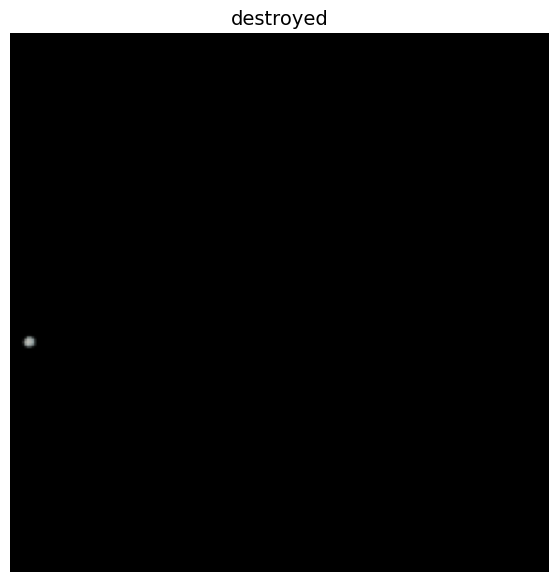

In [253]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

#### Spliting the train into train and validation

In [254]:
trainset = torch.utils.data.Subset(train_dataset, list(range(len(train_dataset))))
testset = torch.utils.data.Subset(test_dataset, list(range(len(test_dataset))))
validset = torch.utils.data.Subset(valid_dataset, list(range(len(valid_dataset))))

In [255]:
batch_size = 128

# prepare data loaders
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=2)
valid_loader = DataLoader(validset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=2)

#### Class Statistics - Class Balance

In [256]:
def get_label_stats(data_loader):
    labels = [labels for i, (images, labels) in enumerate(data_loader)]
    labels = torch.cat((labels), 0)
    labels_count = labels.unique(return_counts=True)
    
    # # print(train_labels_count)
    
    print('The number of samples per classes in training dataset:\n')
    for label, count in zip(labels_count[0], labels_count[1]):
        print('\t {}: {}'.format(label, count))
    return labels, labels_count

In [257]:
# print out classes statistics
train_labels, train_labels_count = get_label_stats(train_loader)

The number of samples per classes in training dataset:

	 0: 757
	 1: 1902
	 2: 5207
	 3: 14588


In [258]:
# #get all test samples labels
valid_labels, valid_labels_count = get_label_stats(valid_loader)

The number of samples per classes in training dataset:

	 0: 285
	 1: 608
	 2: 1722
	 3: 4457


In [259]:
# #get all test samples labels
test_labels, test_labels_count = get_label_stats(test_loader)

The number of samples per classes in training dataset:

	 0: 183
	 1: 409
	 2: 1363
	 3: 3647


In [18]:
class_dict

{'destroyed': 0,
 'major-damage': 1,
 'minor-damage': 2,
 'no-damage': 3,
 'un-classified': 4}

#### Metrics

In [331]:
def get_metrics(preds_list, target_list, num_classes = 4 ):
    pred_ts=tensor(preds_list)
    target_ts = tensor(target_list)
    
    accuracy = multiclass_accuracy(pred_ts, target_ts, num_classes=4)
    
    f1_score = multiclass_f1_score(pred_ts, target_ts, num_classes=4, average="weighted")
    
    precision = multiclass_precision(pred_ts, target_ts, num_classes=4, average="weighted")
    recall = multiclass_recall(pred_ts, target_ts, num_classes=4, average="weighted")
    
    print("Accuracy :", accuracy)
    print("F1-score : ", f1_score)
    print("Precision : ", precision)
    print("Recall : ", recall)

#### Class Imbalance Correction

#### Sampler -  WeightedSampler

In [260]:
def get_class_weights(labels):
    class_counts = np.bincount(labels)
    num_classes = len(class_counts)
    total_samples = len(labels)
    
    class_weights = []
    for count in class_counts:
        weight = 1 / (count / total_samples)
        class_weights.append(weight)
    
    return class_weights

In [261]:
class_weights=get_class_weights(train_labels)
class_weights

[29.661822985468955, 11.80546792849632, 4.312271941617054, 1.5392103098437073]

In [ ]:
#train_imgs = [images for i, (images, labels) in enumerate(train_loader)]

In [262]:
class_weights = torch.tensor(class_weights, dtype=torch.float32).to('cpu')
# balanced sampler
weights = class_weights[train_labels]
ws = WeightedRandomSampler(weights, len(weights), replacement=True)
ws

In [263]:
train_loader_ws = DataLoader(trainset, batch_size=batch_size, sampler=ws , num_workers=2)

In [264]:
train_labels_ws, train_labels_count_ws = get_label_stats(train_loader_ws)

The number of samples per classes in training dataset:

	 0: 5596
	 1: 5597
	 2: 5545
	 3: 5716


### Model Training

In [ ]:
vision_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
vision_transformer

In [266]:
# vit-16 model is trained on ImageNet
# we expect to have output of 1000 number of classes

vision_transformer.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [267]:
# fine-tune with dataset

# change the number of output classes
vision_transformer.heads = nn.Linear(in_features=768, out_features=len(class_names), bias=True)

# freeze the parameters except the last linear layer
#
# freeze weights
for p in vision_transformer.parameters():
    p.requires_grad = False

# unfreeze weights of classification head to train
for p in vision_transformer.heads.parameters():
    p.requires_grad = True

In [ ]:
# check whether corresponding layers are frozen

for layer_name, p in vision_transformer.named_parameters():
    print('Layer Name: {}, Frozen: {}'.format(layer_name, not p.requires_grad))
    print()

In [347]:
# specify loss function
#criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()

#criterion = FocalLoss(alpha=class_weights, gamma=2)
# define optimizer
# only train the parameters with requires_grad set to True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.0001)

optimizer_1 = optim.Adam(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.001)
optimizer_2 = optim.SGD(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.0001)
optimizer_3 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.001,  weight_decay=0.1)
optimizer_4 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.0001,  weight_decay=0.1, amsgrad=True)
optimizer_5 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.0001,  weight_decay=0.1,betas= (0.9,0.999), amsgrad=True)

In [270]:
train_on_gpu = torch.backends.mps.is_available()
train_on_gpu

True

In [31]:
# Train model
def train_vit(device, train_loader, valid_loader, train_on_gpu = False, n_epoch = 10):
    
    train_loss_list, valid_loss_list = [], []
    
    # move model to GPU
    if train_on_gpu:
        print("Device available : ", device)
        vision_transformer.to(device)
    
    # prepare model for training
    vision_transformer.train()
    
    for e in range(n_epoch):
        #print("Start Iteration ", e)
        train_loss = 0.0
        valid_loss = 0.0
    
        # get batch data
        for i, (images, targets) in enumerate(train_loader):
            
            # move to gpu if available
            if train_on_gpu:
                images, targets = images.to(device), targets.to(device)
    
            # clear grad
            optimizer.zero_grad()
    
            # feedforward data
            outputs = vision_transformer(images)
    
            # calculate loss
            loss = criterion(outputs, targets)
    
            # backward pass, calculate gradients
            loss.backward()
    
            # update weights
            optimizer.step()
    
            # track loss
            train_loss += loss.item()
    
        # set model to evaluation mode
        vision_transformer.eval()
    
        # validate model
        for images, targets in valid_loader:
    
            # move to gpu if available
            if train_on_gpu:
                images = images.to(device)
                targets = targets.to(device)
    
            # turn off gradients
            with torch.no_grad():
    
                outputs = vision_transformer(images)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()
    
        # set model back to training mode
        vision_transformer.train()
    
        # get average loss values
        train_loss = train_loss / len(train_loader)
        valid_loss = valid_loss / len(valid_loader)
    
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
    
        # output training statistics for epoch
        print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                      .format( (e+1), train_loss, valid_loss))
        #print("Completed Iteration ", e)
    return train_loss_list, valid_loss_list

In [30]:
def plot_losses(train_loss_list, valid_loss_list):
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    # plot losses
    x = list(range(1, n_epoch + 1))
    plt.plot(x, train_loss_list, color ="blue", label='Train')
    plt.plot(x, valid_loss_list, color="orange", label='Validation')
    plt.legend(loc="upper right")
    plt.xticks(x)
    
    plt.show()

#### Evaluation

In [36]:
def eval_vit(vision_transformer,class_names, test_loader, class_weights, device='cpu'):
    # prepare model for evaluation
    vision_transformer.eval()
    
    class_weights = class_weights.to(device)
    
    test_loss = 0.0
    accuracy = 0
    
    # number of classes
    n_class = len(class_names)
    
    class_correct = np.zeros(n_class)
    class_total = np.zeros(n_class)
    
    # move model back to cpu
    vision_transformer = vision_transformer.to(device)
    
    # test model
    for images, targets in test_loader:
    
        # get outputs
        outputs = vision_transformer(images)
    
        # calculate loss
        loss = criterion(outputs, targets)
    
        # track loss
        test_loss += loss.item()
    
        # get predictions from probabilities
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    
        # get correct predictions
        correct_preds = (preds == targets).type(torch.FloatTensor)
    
        # calculate and accumulate accuracy
        accuracy += torch.mean(correct_preds).item() * 100
    
        # calculate test accuracy for each class
        for c in range(n_class):
    
            targets = targets.to(device)
    
            class_total[c] += (targets == c).sum()
            class_correct[c] += ((correct_preds) * (targets == c)).sum()
    
    # get average accuracy
    accuracy = accuracy / len(test_loader)
    
    # get average loss
    test_loss = test_loss / len(test_loader)
    
    # output test loss statistics
    print('Test Loss: {:.6f}'.format(test_loss))
    return class_correct, class_total

In [37]:
def accuracy_per_class(class_correct, class_total, class_names ):
    n_class = len(class_names)

    class_accuracy = class_correct / class_total

    print('Test Accuracy of Classes')
    print()
    
    for c in range(n_class):
        print('{}\t: {}% \t ({}/{})'.format(class_names[c],
                                    int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])) )
    
    print()
    print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),
                                                               int(np.sum(class_correct)), int(np.sum(class_total)) ))
    

#### Training & Evaluation using Weighted Sampler

#### Epoches =5

In [32]:
train_loss_list_ws, valid_loss_list_ws = train_vit(device, train_loader_ws , valid_loader, train_on_gpu = True, n_epoch = 5)

Device available :  mps
Start Iteration  0
Epoch: 1 	 Training Loss: 1.594629 	 Validation Loss: 1.648056
Completed Iteration  0
Start Iteration  1
Epoch: 2 	 Training Loss: 1.564477 	 Validation Loss: 1.563349
Completed Iteration  1
Start Iteration  2
Epoch: 3 	 Training Loss: 1.544417 	 Validation Loss: 1.618612
Completed Iteration  2
Start Iteration  3
Epoch: 4 	 Training Loss: 1.530884 	 Validation Loss: 1.563632
Completed Iteration  3
Start Iteration  4
Epoch: 5 	 Training Loss: 1.521391 	 Validation Loss: 1.535777
Completed Iteration  4


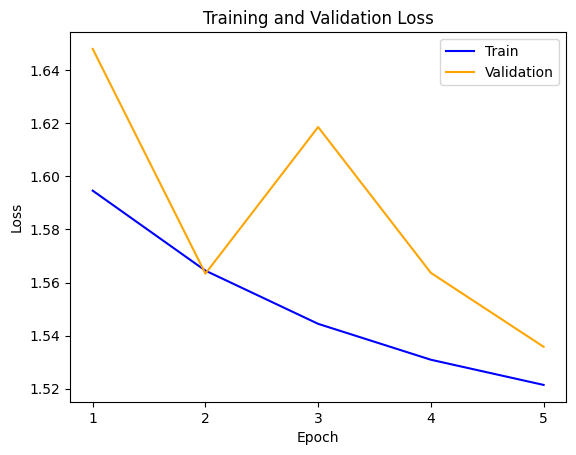

In [34]:
n_epoch = 5
plot_losses(train_loss_list_ws, valid_loss_list_ws)

In [42]:
    n_epoch = 5
    train_loss_list, valid_loss_list = [], []
    
    # move model to GPU
    if train_on_gpu:
        print("Device available : ", device)
        vision_transformer.to(device)
    
    # prepare model for training
    vision_transformer.train()
    
    for e in range(n_epoch):
        #print("Start Iteration ", e)
        train_loss = 0.0
        valid_loss = 0.0
    
        # get batch data
        for i, (images, targets) in enumerate(train_loader):
            
            # move to gpu if available
            if train_on_gpu:
                images, targets = images.to(device), targets.to(device)
    
            # clear grad
            optimizer.zero_grad()
    
            # feedforward data
            outputs = vision_transformer(images)
    
            # calculate loss
            loss = criterion(outputs, targets)
    
            # backward pass, calculate gradients
            loss.backward()
    
            # update weights
            optimizer.step()
    
            # track loss
            train_loss += loss.item()
    
        # set model to evaluation mode
        vision_transformer.eval()
    
        # validate model
        for images, targets in valid_loader:
    
            # move to gpu if available
            if train_on_gpu:
                images = images.to(device)
                targets = targets.to(device)
    
            # turn off gradients
            with torch.no_grad():
    
                outputs = vision_transformer(images)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()
    
        # set model back to training mode
        vision_transformer.train()
    
        # get average loss values
        train_loss = train_loss / len(train_loader)
        valid_loss = valid_loss / len(valid_loader)
    
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
    
        # output training statistics for epoch
        print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                      .format( (e+1), train_loss, valid_loss))
        #print("Completed Iteration ", e)

Device available :  mps
Epoch: 1 	 Training Loss: 1.029876 	 Validation Loss: 1.570930
Epoch: 2 	 Training Loss: 1.131172 	 Validation Loss: 1.426397
Epoch: 3 	 Training Loss: 1.118510 	 Validation Loss: 1.368962
Epoch: 4 	 Training Loss: 1.114036 	 Validation Loss: 1.336934
Epoch: 5 	 Training Loss: 1.111377 	 Validation Loss: 1.316477


In [44]:
# prepare model for evaluation
vision_transformer.eval()

class_weights = class_weights.to('cpu')

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(class_names)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in test_loader:

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))

Test Loss: 1.288538


In [45]:
accuracy_per_class(class_correct, class_total, class_names)

Test Accuracy of Classes

destroyed	: 0% 	 (0/183)
major-damage	: 0% 	 (0/409)
minor-damage	: 0% 	 (0/1363)
no-damage	: 100% 	 (3647/3647)
un-classified	: 0% 	 (0/55)

Test Accuracy of Dataset: 	 63% 	 (3647/5657)


#### Epoches =15, lr=0.0001

In [333]:
    n_epoch = 15
    data = train_loader_ws
    train_loss_list, valid_loss_list = [], []
    
    # move model to GPU
    if train_on_gpu:
        print("Device available : ", device)
        vision_transformer.to(device)
    
    # prepare model for training
    vision_transformer.train()
    
    for e in range(n_epoch):
        #print("Start Iteration ", e)
        train_loss = 0.0
        valid_loss = 0.0
    
        # get batch data
        for i, (images, targets) in enumerate(data):
            
            # move to gpu if available
            if train_on_gpu:
                images, targets = images.to(device), targets.to(device)
    
            # clear grad
            optimizer.zero_grad()
    
            # feedforward data
            outputs = vision_transformer(images)
    
            # calculate loss
            loss = criterion(outputs, targets)
    
            # backward pass, calculate gradients
            loss.backward()
    
            # update weights
            optimizer.step()
    
            # track loss
            train_loss += loss.item()
    
        # set model to evaluation mode
        vision_transformer.eval()
    
        # validate model
        for images, targets in valid_loader:
    
            # move to gpu if available
            if train_on_gpu:
                images = images.to(device)
                targets = targets.to(device)
    
            # turn off gradients
            with torch.no_grad():
    
                outputs = vision_transformer(images)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()
    
        # set model back to training mode
        vision_transformer.train()
    
        # get average loss values
        train_loss = train_loss / len(data)
        valid_loss = valid_loss / len(valid_loader)
    
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
    
        # output training statistics for epoch
        print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                      .format( (e+1), train_loss, valid_loss))

Device available :  mps
Epoch: 1 	 Training Loss: 1.245873 	 Validation Loss: 1.325884
Epoch: 2 	 Training Loss: 1.250325 	 Validation Loss: 1.316489
Epoch: 3 	 Training Loss: 1.246971 	 Validation Loss: 1.288684
Epoch: 4 	 Training Loss: 1.243357 	 Validation Loss: 1.359040
Epoch: 5 	 Training Loss: 1.242185 	 Validation Loss: 1.310385
Epoch: 6 	 Training Loss: 1.239688 	 Validation Loss: 1.330525
Epoch: 7 	 Training Loss: 1.242410 	 Validation Loss: 1.350666
Epoch: 8 	 Training Loss: 1.245293 	 Validation Loss: 1.349686
Epoch: 9 	 Training Loss: 1.240974 	 Validation Loss: 1.339709
Epoch: 10 	 Training Loss: 1.245327 	 Validation Loss: 1.284389
Epoch: 11 	 Training Loss: 1.247945 	 Validation Loss: 1.331089
Epoch: 12 	 Training Loss: 1.244745 	 Validation Loss: 1.325484
Epoch: 13 	 Training Loss: 1.245380 	 Validation Loss: 1.343424
Epoch: 14 	 Training Loss: 1.245534 	 Validation Loss: 1.316287
Epoch: 15 	 Training Loss: 1.246572 	 Validation Loss: 1.378443


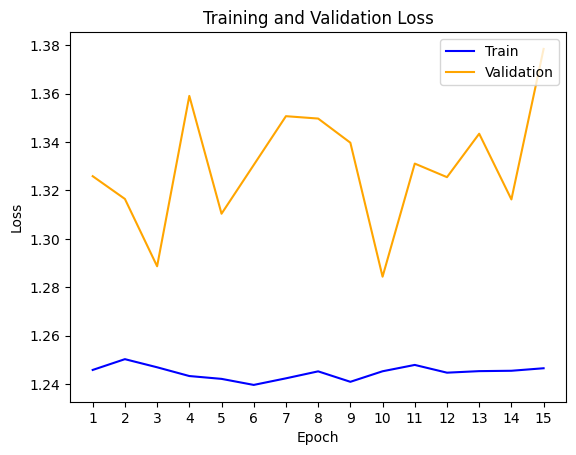

In [334]:
n_epoch = 15
plot_losses(train_loss_list, valid_loss_list)

In [335]:
# prepare model for evaluation
vision_transformer.eval()

class_weights = class_weights.to('cpu')
preds_list = []
target_list = []
output_list = []

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(class_names)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in test_loader:

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    target_list.extend(targets)
    output_list.extend(torch.argmax(F.softmax(outputs, dim=1), dim=1 ))
    preds_list.extend(preds)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))

Test Loss: 1.378722


In [336]:
accuracy_per_class(class_correct, class_total, class_names)

Test Accuracy of Classes

destroyed	: 56% 	 (104/183)
major-damage	: 46% 	 (192/409)
minor-damage	: 44% 	 (605/1363)
no-damage	: 10% 	 (386/3647)

Test Accuracy of Dataset: 	 22% 	 (1287/5602)


In [337]:
get_metrics(preds_list, target_list)

Accuracy : tensor(0.2297)
F1-score :  tensor(0.2226)
Precision :  tensor(0.5412)
Recall :  tensor(0.2297)


#### SGD, lr=0.0001, epoches =15

Device available :  mps
Epoch: 1 	 Training Loss: 1.239651 	 Validation Loss: 1.348296
Epoch: 2 	 Training Loss: 1.245380 	 Validation Loss: 1.334361
Epoch: 3 	 Training Loss: 1.245629 	 Validation Loss: 1.330823
Epoch: 4 	 Training Loss: 1.238891 	 Validation Loss: 1.329055
Epoch: 5 	 Training Loss: 1.244169 	 Validation Loss: 1.319541
Epoch: 6 	 Training Loss: 1.246443 	 Validation Loss: 1.317264
Epoch: 7 	 Training Loss: 1.246368 	 Validation Loss: 1.321291
Epoch: 8 	 Training Loss: 1.245319 	 Validation Loss: 1.328337
Epoch: 9 	 Training Loss: 1.242710 	 Validation Loss: 1.322025
Epoch: 10 	 Training Loss: 1.245352 	 Validation Loss: 1.326792
Epoch: 11 	 Training Loss: 1.242627 	 Validation Loss: 1.325302
Epoch: 12 	 Training Loss: 1.241309 	 Validation Loss: 1.320706
Epoch: 13 	 Training Loss: 1.245916 	 Validation Loss: 1.324595
Epoch: 14 	 Training Loss: 1.243944 	 Validation Loss: 1.319469
Epoch: 15 	 Training Loss: 1.242592 	 Validation Loss: 1.317934


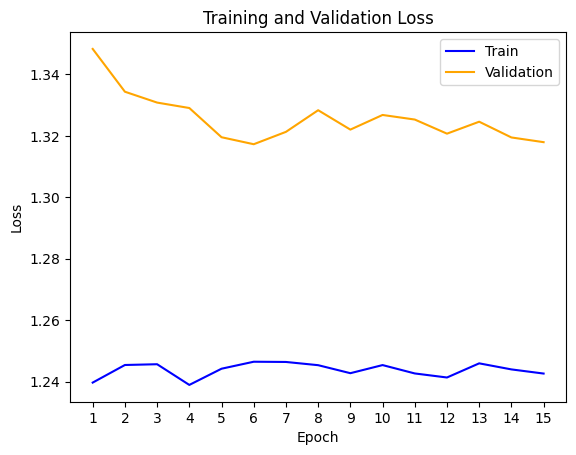

Test Loss: 1.315578
Test Accuracy of Classes

destroyed	: 56% 	 (104/183)
major-damage	: 45% 	 (187/409)
minor-damage	: 30% 	 (418/1363)
no-damage	: 26% 	 (976/3647)

Test Accuracy of Dataset: 	 30% 	 (1685/5602)
Accuracy : tensor(0.3008)
F1-score :  tensor(0.3431)
Precision :  tensor(0.5326)
Recall :  tensor(0.3008)


In [339]:
n_epoch = 15

data = train_loader_ws
train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    print("Device available : ", device)
    vision_transformer.to(device)

# prepare model for training
vision_transformer.train()

for e in range(n_epoch):
    #print("Start Iteration ", e)
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in enumerate(data):
        
        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to(device), targets.to(device)

        # clear grad
        optimizer_2.zero_grad()

        # feedforward data
        outputs = vision_transformer(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer_2.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    vision_transformer.eval()

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to(device)
            targets = targets.to(device)

        # turn off gradients
        with torch.no_grad():

            outputs = vision_transformer(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    vision_transformer.train()

    # get average loss values
    train_loss = train_loss / len(data)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                  .format( (e+1), train_loss, valid_loss))


plot_losses(train_loss_list, valid_loss_list)

# prepare model for evaluation
vision_transformer.eval()

class_weights = class_weights.to('cpu')
preds_list = []
target_list = []
output_list = []

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(class_names)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in test_loader:

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    target_list.extend(targets)
    output_list.extend(torch.argmax(F.softmax(outputs, dim=1), dim=1 ))
    preds_list.extend(preds)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))

accuracy_per_class(class_correct, class_total, class_names)

get_metrics(preds_list, target_list)

#### Epoches =20, LR=0.001

In [279]:
    n_epoch = 20
    data = train_loader_ws
    train_loss_list, valid_loss_list = [], []
    
    # move model to GPU
    if train_on_gpu:
        print("Device available : ", device)
        vision_transformer.to(device)
    
    # prepare model for training
    vision_transformer.train()
    
    for e in range(n_epoch):
        #print("Start Iteration ", e)
        train_loss = 0.0
        valid_loss = 0.0
    
        # get batch data
        for i, (images, targets) in enumerate(data):
            
            # move to gpu if available
            if train_on_gpu:
                images, targets = images.to(device), targets.to(device)
    
            # clear grad
            optimizer_1.zero_grad()
    
            # feedforward data
            outputs = vision_transformer(images)
    
            # calculate loss
            loss = criterion(outputs, targets)
    
            # backward pass, calculate gradients
            loss.backward()
    
            # update weights
            optimizer_1.step()
    
            # track loss
            train_loss += loss.item()
    
        # set model to evaluation mode
        vision_transformer.eval()
    
        # validate model
        for images, targets in valid_loader:
    
            # move to gpu if available
            if train_on_gpu:
                images = images.to(device)
                targets = targets.to(device)
    
            # turn off gradients
            with torch.no_grad():
    
                outputs = vision_transformer(images)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()
    
        # set model back to training mode
        vision_transformer.train()
    
        # get average loss values
        train_loss = train_loss / len(data)
        valid_loss = valid_loss / len(valid_loader)
    
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
    
        # output training statistics for epoch
        print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                      .format( (e+1), train_loss, valid_loss))

Device available :  mps
Epoch: 1 	 Training Loss: 1.316357 	 Validation Loss: 1.340290
Epoch: 2 	 Training Loss: 1.297129 	 Validation Loss: 1.354300
Epoch: 3 	 Training Loss: 1.291978 	 Validation Loss: 1.350017
Epoch: 4 	 Training Loss: 1.287721 	 Validation Loss: 1.393980
Epoch: 5 	 Training Loss: 1.282067 	 Validation Loss: 1.458812
Epoch: 6 	 Training Loss: 1.274431 	 Validation Loss: 1.422644
Epoch: 7 	 Training Loss: 1.274786 	 Validation Loss: 1.232070
Epoch: 8 	 Training Loss: 1.266894 	 Validation Loss: 1.237244
Epoch: 9 	 Training Loss: 1.275054 	 Validation Loss: 1.261387
Epoch: 10 	 Training Loss: 1.266797 	 Validation Loss: 1.324771
Epoch: 11 	 Training Loss: 1.266176 	 Validation Loss: 1.375170
Epoch: 12 	 Training Loss: 1.262144 	 Validation Loss: 1.287203
Epoch: 13 	 Training Loss: 1.266063 	 Validation Loss: 1.403027
Epoch: 14 	 Training Loss: 1.260921 	 Validation Loss: 1.215971
Epoch: 15 	 Training Loss: 1.253648 	 Validation Loss: 1.400056
Epoch: 16 	 Training Loss

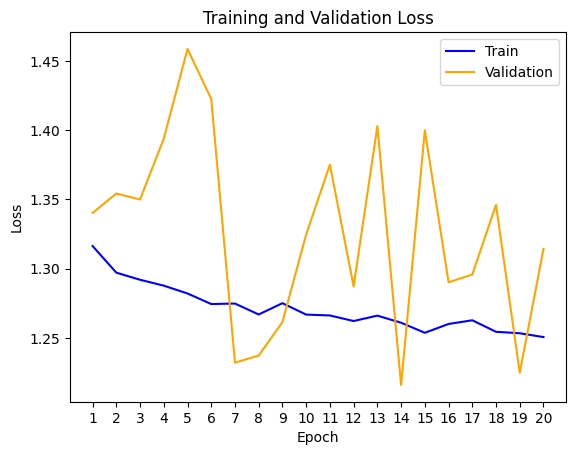

In [280]:
n_epoch =  20
plot_losses(train_loss_list, valid_loss_list)

In [323]:
# prepare model for evaluation
vision_transformer.eval()

class_weights = class_weights.to('cpu')

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(class_names)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

preds_list = []
target_list = []
output_list = []
# move model back to cpu
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in test_loader:

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    target_list.extend(targets)
    output_list.extend(torch.argmax(F.softmax(outputs, dim=1), dim=1 ))
    preds_list.extend(preds)
    
    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))

Test Loss: 1.310831


In [282]:
accuracy_per_class(class_correct, class_total, class_names)

Test Accuracy of Classes

destroyed	: 56% 	 (104/183)
major-damage	: 40% 	 (166/409)
minor-damage	: 36% 	 (492/1363)
no-damage	: 27% 	 (1003/3647)

Test Accuracy of Dataset: 	 31% 	 (1765/5602)


In [332]:
get_metrics(preds_list, target_list)

Accuracy : tensor(0.3151)
F1-score :  tensor(0.3567)
Precision :  tensor(0.5431)
Recall :  tensor(0.3151)


#### Epoches=20, LR=0.001, SGD

Device available :  mps
Epoch: 1 	 Training Loss: 1.240639 	 Validation Loss: 1.327829
Epoch: 2 	 Training Loss: 1.243893 	 Validation Loss: 1.318993
Epoch: 3 	 Training Loss: 1.241981 	 Validation Loss: 1.315813
Epoch: 4 	 Training Loss: 1.241341 	 Validation Loss: 1.316272
Epoch: 5 	 Training Loss: 1.236907 	 Validation Loss: 1.318063
Epoch: 6 	 Training Loss: 1.244735 	 Validation Loss: 1.319163
Epoch: 7 	 Training Loss: 1.242701 	 Validation Loss: 1.327296
Epoch: 8 	 Training Loss: 1.241651 	 Validation Loss: 1.316531
Epoch: 9 	 Training Loss: 1.243775 	 Validation Loss: 1.321305
Epoch: 10 	 Training Loss: 1.239334 	 Validation Loss: 1.329931
Epoch: 11 	 Training Loss: 1.245101 	 Validation Loss: 1.326239
Epoch: 12 	 Training Loss: 1.236268 	 Validation Loss: 1.334074
Epoch: 13 	 Training Loss: 1.243560 	 Validation Loss: 1.325766
Epoch: 14 	 Training Loss: 1.248542 	 Validation Loss: 1.320473
Epoch: 15 	 Training Loss: 1.243165 	 Validation Loss: 1.323415
Epoch: 16 	 Training Loss

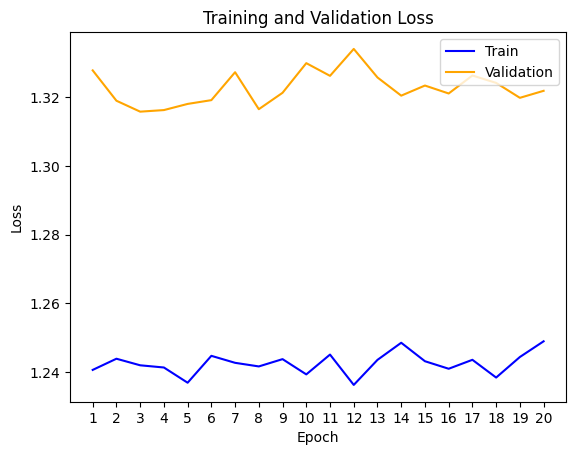

Test Loss: 1.319921
Test Accuracy of Classes

destroyed	: 56% 	 (104/183)
major-damage	: 45% 	 (188/409)
minor-damage	: 31% 	 (436/1363)
no-damage	: 24% 	 (889/3647)

Test Accuracy of Dataset: 	 28% 	 (1617/5602)
Accuracy : tensor(0.2886)
F1-score :  tensor(0.3267)
Precision :  tensor(0.5272)
Recall :  tensor(0.2886)


In [340]:
n_epoch = 20

data = train_loader_ws
train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    print("Device available : ", device)
    vision_transformer.to(device)

# prepare model for training
vision_transformer.train()

for e in range(n_epoch):
    #print("Start Iteration ", e)
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in enumerate(data):
        
        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to(device), targets.to(device)

        # clear grad
        optimizer_2.zero_grad()

        # feedforward data
        outputs = vision_transformer(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer_2.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    vision_transformer.eval()

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to(device)
            targets = targets.to(device)

        # turn off gradients
        with torch.no_grad():

            outputs = vision_transformer(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    vision_transformer.train()

    # get average loss values
    train_loss = train_loss / len(data)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                  .format( (e+1), train_loss, valid_loss))


plot_losses(train_loss_list, valid_loss_list)

# prepare model for evaluation
vision_transformer.eval()

class_weights = class_weights.to('cpu')
preds_list = []
target_list = []
output_list = []

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(class_names)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in test_loader:

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    target_list.extend(targets)
    output_list.extend(torch.argmax(F.softmax(outputs, dim=1), dim=1 ))
    preds_list.extend(preds)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))

accuracy_per_class(class_correct, class_total, class_names)

get_metrics(preds_list, target_list)

#### AdamW, lr = 0.001, epoches = 25

Device available :  mps
Epoch: 1 	 Training Loss: 1.249004 	 Validation Loss: 1.331061
Epoch: 2 	 Training Loss: 1.244185 	 Validation Loss: 1.434451
Epoch: 3 	 Training Loss: 1.259739 	 Validation Loss: 1.427719
Epoch: 4 	 Training Loss: 1.244176 	 Validation Loss: 1.262118
Epoch: 5 	 Training Loss: 1.250406 	 Validation Loss: 1.311234
Epoch: 6 	 Training Loss: 1.244750 	 Validation Loss: 1.322507
Epoch: 7 	 Training Loss: 1.248148 	 Validation Loss: 1.248248
Epoch: 8 	 Training Loss: 1.249133 	 Validation Loss: 1.249524
Epoch: 9 	 Training Loss: 1.248847 	 Validation Loss: 1.364625
Epoch: 10 	 Training Loss: 1.245665 	 Validation Loss: 1.350318
Epoch: 11 	 Training Loss: 1.241589 	 Validation Loss: 1.328718
Epoch: 12 	 Training Loss: 1.248242 	 Validation Loss: 1.455767
Epoch: 13 	 Training Loss: 1.238747 	 Validation Loss: 1.271154
Epoch: 14 	 Training Loss: 1.241676 	 Validation Loss: 1.277152
Epoch: 15 	 Training Loss: 1.239818 	 Validation Loss: 1.354841
Epoch: 16 	 Training Loss

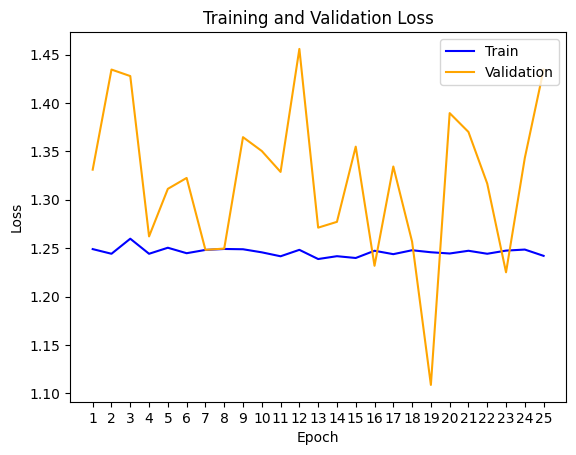

Test Loss: 1.434785
Test Accuracy of Classes

destroyed	: 57% 	 (105/183)
major-damage	: 55% 	 (226/409)
minor-damage	: 31% 	 (423/1363)
no-damage	: 10% 	 (366/3647)

Test Accuracy of Dataset: 	 19% 	 (1120/5602)
Accuracy : tensor(0.1999)
F1-score :  tensor(0.2028)
Precision :  tensor(0.5313)
Recall :  tensor(0.1999)


In [342]:
n_epoch = 25

data = train_loader_ws
train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    print("Device available : ", device)
    vision_transformer.to(device)

# prepare model for training
vision_transformer.train()

for e in range(n_epoch):
    #print("Start Iteration ", e)
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in enumerate(data):
        
        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to(device), targets.to(device)

        # clear grad
        optimizer_3.zero_grad()

        # feedforward data
        outputs = vision_transformer(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer_3.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    vision_transformer.eval()

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to(device)
            targets = targets.to(device)

        # turn off gradients
        with torch.no_grad():

            outputs = vision_transformer(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    vision_transformer.train()

    # get average loss values
    train_loss = train_loss / len(data)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                  .format( (e+1), train_loss, valid_loss))


plot_losses(train_loss_list, valid_loss_list)

# prepare model for evaluation
vision_transformer.eval()

class_weights = class_weights.to('cpu')
preds_list = []
target_list = []
output_list = []

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(class_names)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in test_loader:

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    target_list.extend(targets)
    output_list.extend(torch.argmax(F.softmax(outputs, dim=1), dim=1 ))
    preds_list.extend(preds)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))

accuracy_per_class(class_correct, class_total, class_names)

get_metrics(preds_list, target_list)

Device available :  mps
Epoch: 1 	 Training Loss: 1.237044 	 Validation Loss: 1.373934
Epoch: 2 	 Training Loss: 1.239829 	 Validation Loss: 1.344744
Epoch: 3 	 Training Loss: 1.237709 	 Validation Loss: 1.315459
Epoch: 4 	 Training Loss: 1.235506 	 Validation Loss: 1.283663
Epoch: 5 	 Training Loss: 1.238437 	 Validation Loss: 1.334226
Epoch: 6 	 Training Loss: 1.238066 	 Validation Loss: 1.287562
Epoch: 7 	 Training Loss: 1.230483 	 Validation Loss: 1.307323
Epoch: 8 	 Training Loss: 1.234290 	 Validation Loss: 1.299232
Epoch: 9 	 Training Loss: 1.236037 	 Validation Loss: 1.293698
Epoch: 10 	 Training Loss: 1.235020 	 Validation Loss: 1.329342
Epoch: 11 	 Training Loss: 1.233632 	 Validation Loss: 1.333398
Epoch: 12 	 Training Loss: 1.239116 	 Validation Loss: 1.327663
Epoch: 13 	 Training Loss: 1.235663 	 Validation Loss: 1.346922
Epoch: 14 	 Training Loss: 1.234294 	 Validation Loss: 1.336554
Epoch: 15 	 Training Loss: 1.236995 	 Validation Loss: 1.316039
Epoch: 16 	 Training Loss

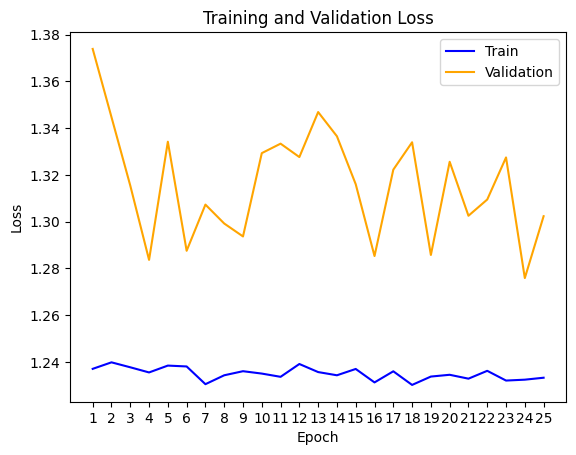

Test Loss: 1.298543
Test Accuracy of Classes

destroyed	: 56% 	 (104/183)
major-damage	: 40% 	 (167/409)
minor-damage	: 36% 	 (503/1363)
no-damage	: 26% 	 (974/3647)

Test Accuracy of Dataset: 	 31% 	 (1748/5602)
Accuracy : tensor(0.3120)
F1-score :  tensor(0.3497)
Precision :  tensor(0.5331)
Recall :  tensor(0.3120)


In [345]:
n_epoch = 25

data = train_loader_ws
train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    print("Device available : ", device)
    vision_transformer.to(device)

# prepare model for training
vision_transformer.train()

for e in range(n_epoch):
    #print("Start Iteration ", e)
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in enumerate(data):
        
        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to(device), targets.to(device)

        # clear grad
        optimizer_4.zero_grad()

        # feedforward data
        outputs = vision_transformer(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer_4.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    vision_transformer.eval()

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to(device)
            targets = targets.to(device)

        # turn off gradients
        with torch.no_grad():

            outputs = vision_transformer(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    vision_transformer.train()

    # get average loss values
    train_loss = train_loss / len(data)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                  .format( (e+1), train_loss, valid_loss))


plot_losses(train_loss_list, valid_loss_list)

# prepare model for evaluation
vision_transformer.eval()

class_weights = class_weights.to('cpu')
preds_list = []
target_list = []
output_list = []

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(class_names)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in test_loader:

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    target_list.extend(targets)
    output_list.extend(torch.argmax(F.softmax(outputs, dim=1), dim=1 ))
    preds_list.extend(preds)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))

accuracy_per_class(class_correct, class_total, class_names)

get_metrics(preds_list, target_list)

#### Optimizer 5 # lr = 0.0001, weight_decay = 0.1, 

Device available :  mps
Epoch: 1 	 Training Loss: 1.238918 	 Validation Loss: 1.320919
Epoch: 2 	 Training Loss: 1.236217 	 Validation Loss: 1.322477
Epoch: 3 	 Training Loss: 1.232485 	 Validation Loss: 1.294480
Epoch: 4 	 Training Loss: 1.238239 	 Validation Loss: 1.346998
Epoch: 5 	 Training Loss: 1.233489 	 Validation Loss: 1.269931
Epoch: 6 	 Training Loss: 1.234222 	 Validation Loss: 1.248710
Epoch: 7 	 Training Loss: 1.238504 	 Validation Loss: 1.309722
Epoch: 8 	 Training Loss: 1.238815 	 Validation Loss: 1.366671
Epoch: 9 	 Training Loss: 1.239421 	 Validation Loss: 1.329865
Epoch: 10 	 Training Loss: 1.233983 	 Validation Loss: 1.327773
Epoch: 11 	 Training Loss: 1.234902 	 Validation Loss: 1.311304
Epoch: 12 	 Training Loss: 1.233680 	 Validation Loss: 1.323006
Epoch: 13 	 Training Loss: 1.232595 	 Validation Loss: 1.305425
Epoch: 14 	 Training Loss: 1.237563 	 Validation Loss: 1.327200
Epoch: 15 	 Training Loss: 1.237231 	 Validation Loss: 1.350216
Epoch: 16 	 Training Loss

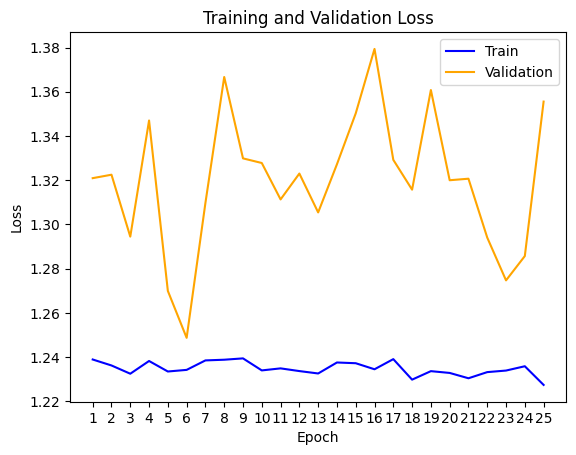

Test Loss: 1.354432
Test Accuracy of Classes

destroyed	: 59% 	 (108/183)
major-damage	: 44% 	 (184/409)
minor-damage	: 35% 	 (481/1363)
no-damage	: 18% 	 (685/3647)

Test Accuracy of Dataset: 	 26% 	 (1458/5602)
Accuracy : tensor(0.2603)
F1-score :  tensor(0.2873)
Precision :  tensor(0.5265)
Recall :  tensor(0.2603)


In [348]:
n_epoch = 25

data = train_loader_ws
train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    print("Device available : ", device)
    vision_transformer.to(device)

# prepare model for training
vision_transformer.train()

for e in range(n_epoch):
    #print("Start Iteration ", e)
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in enumerate(data):
        
        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to(device), targets.to(device)

        # clear grad
        optimizer_5.zero_grad()

        # feedforward data
        outputs = vision_transformer(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer_5.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    vision_transformer.eval()

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to(device)
            targets = targets.to(device)

        # turn off gradients
        with torch.no_grad():

            outputs = vision_transformer(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    vision_transformer.train()

    # get average loss values
    train_loss = train_loss / len(data)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                  .format( (e+1), train_loss, valid_loss))


plot_losses(train_loss_list, valid_loss_list)

# prepare model for evaluation
vision_transformer.eval()

class_weights = class_weights.to('cpu')
preds_list = []
target_list = []
output_list = []

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(class_names)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in test_loader:

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    target_list.extend(targets)
    output_list.extend(torch.argmax(F.softmax(outputs, dim=1), dim=1 ))
    preds_list.extend(preds)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))

accuracy_per_class(class_correct, class_total, class_names)

get_metrics(preds_list, target_list)

Device available :  mps
Epoch: 1 	 Training Loss: 1.236554 	 Validation Loss: 1.312716
Epoch: 2 	 Training Loss: 1.233499 	 Validation Loss: 1.342757
Epoch: 3 	 Training Loss: 1.233711 	 Validation Loss: 1.281317
Epoch: 4 	 Training Loss: 1.233389 	 Validation Loss: 1.302908
Epoch: 5 	 Training Loss: 1.232338 	 Validation Loss: 1.292276
Epoch: 6 	 Training Loss: 1.234326 	 Validation Loss: 1.305369
Epoch: 7 	 Training Loss: 1.237371 	 Validation Loss: 1.311667
Epoch: 8 	 Training Loss: 1.237297 	 Validation Loss: 1.311448
Epoch: 9 	 Training Loss: 1.236146 	 Validation Loss: 1.320021
Epoch: 10 	 Training Loss: 1.233103 	 Validation Loss: 1.343458
Epoch: 11 	 Training Loss: 1.232295 	 Validation Loss: 1.365919
Epoch: 12 	 Training Loss: 1.233436 	 Validation Loss: 1.304711
Epoch: 13 	 Training Loss: 1.234715 	 Validation Loss: 1.341531
Epoch: 14 	 Training Loss: 1.233983 	 Validation Loss: 1.360698
Epoch: 15 	 Training Loss: 1.233269 	 Validation Loss: 1.316774
Epoch: 16 	 Training Loss

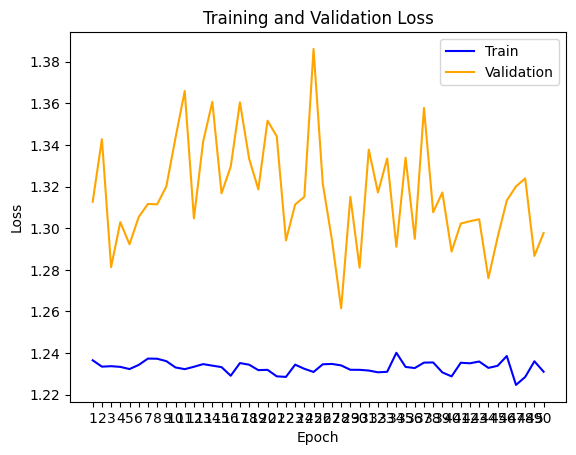

Test Loss: 1.294186
Test Accuracy of Classes

destroyed	: 56% 	 (103/183)
major-damage	: 50% 	 (207/409)
minor-damage	: 21% 	 (293/1363)
no-damage	: 35% 	 (1281/3647)

Test Accuracy of Dataset: 	 33% 	 (1884/5602)
Accuracy : tensor(0.3363)
F1-score :  tensor(0.3855)
Precision :  tensor(0.5395)
Recall :  tensor(0.3363)


In [349]:
n_epoch = 50

data = train_loader_ws
train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    print("Device available : ", device)
    vision_transformer.to(device)

# prepare model for training
vision_transformer.train()

for e in range(n_epoch):
    #print("Start Iteration ", e)
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in enumerate(data):
        
        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to(device), targets.to(device)

        # clear grad
        optimizer_5.zero_grad()

        # feedforward data
        outputs = vision_transformer(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer_5.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    vision_transformer.eval()

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to(device)
            targets = targets.to(device)

        # turn off gradients
        with torch.no_grad():

            outputs = vision_transformer(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    vision_transformer.train()

    # get average loss values
    train_loss = train_loss / len(data)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                  .format( (e+1), train_loss, valid_loss))


plot_losses(train_loss_list, valid_loss_list)

# prepare model for evaluation
vision_transformer.eval()

class_weights = class_weights.to('cpu')
preds_list = []
target_list = []
output_list = []

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(class_names)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in test_loader:

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    target_list.extend(targets)
    output_list.extend(torch.argmax(F.softmax(outputs, dim=1), dim=1 ))
    preds_list.extend(preds)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))

accuracy_per_class(class_correct, class_total, class_names)

get_metrics(preds_list, target_list)

### epoches = 50 + Weighted Samples

In [52]:
    n_epoch = 50
    data = train_loader_ws

    train_loss_list, valid_loss_list = [], []
    
    # move model to GPU
    if train_on_gpu:
        print("Device available : ", device)
        vision_transformer.to(device)
    
    # prepare model for training
    vision_transformer.train()
    
    for e in range(n_epoch):
        #print("Start Iteration ", e)
        train_loss = 0.0
        valid_loss = 0.0
    
        # get batch data
        for i, (images, targets) in enumerate(data):
            
            # move to gpu if available
            if train_on_gpu:
                images, targets = images.to(device), targets.to(device)
    
            # clear grad
            optimizer.zero_grad()
    
            # feedforward data
            outputs = vision_transformer(images)
    
            # calculate loss
            loss = criterion(outputs, targets)
    
            # backward pass, calculate gradients
            loss.backward()
    
            # update weights
            optimizer.step()
    
            # track loss
            train_loss += loss.item()
    
        # set model to evaluation mode
        vision_transformer.eval()
    
        # validate model
        for images, targets in valid_loader:
    
            # move to gpu if available
            if train_on_gpu:
                images = images.to(device)
                targets = targets.to(device)
    
            # turn off gradients
            with torch.no_grad():
    
                outputs = vision_transformer(images)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()
    
        # set model back to training mode
        vision_transformer.train()
    
        # get average loss values
        train_loss = train_loss / len(data)
        valid_loss = valid_loss / len(valid_loader)
    
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
    
        # output training statistics for epoch
        print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                      .format( (e+1), train_loss, valid_loss))

Device available :  mps
Epoch: 1 	 Training Loss: 1.462272 	 Validation Loss: 1.577855
Epoch: 2 	 Training Loss: 1.467690 	 Validation Loss: 1.565859
Epoch: 3 	 Training Loss: 1.463111 	 Validation Loss: 1.537547
Epoch: 4 	 Training Loss: 1.461327 	 Validation Loss: 1.534194
Epoch: 5 	 Training Loss: 1.463937 	 Validation Loss: 1.576116
Epoch: 6 	 Training Loss: 1.454231 	 Validation Loss: 1.588257
Epoch: 7 	 Training Loss: 1.458326 	 Validation Loss: 1.563322
Epoch: 8 	 Training Loss: 1.459566 	 Validation Loss: 1.580744
Epoch: 9 	 Training Loss: 1.458036 	 Validation Loss: 1.573369
Epoch: 10 	 Training Loss: 1.459138 	 Validation Loss: 1.550074
Epoch: 11 	 Training Loss: 1.455070 	 Validation Loss: 1.552075
Epoch: 12 	 Training Loss: 1.459889 	 Validation Loss: 1.605212
Epoch: 13 	 Training Loss: 1.447965 	 Validation Loss: 1.529629
Epoch: 14 	 Training Loss: 1.452617 	 Validation Loss: 1.558143
Epoch: 15 	 Training Loss: 1.452465 	 Validation Loss: 1.572528
Epoch: 16 	 Training Loss

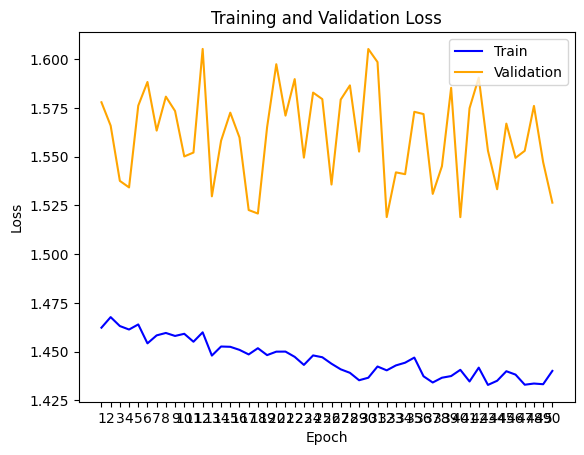

In [53]:
n_epoch = 50
plot_losses(train_loss_list, valid_loss_list)

In [72]:
# prepare model for evaluation
vision_transformer.eval()

class_weights = class_weights.to('cpu')

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(class_names)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

predictions_labels = []
actual_labels = []

# move model back to cpu
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in test_loader:

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    predictions_labels.extend(preds)
    actual_labels.extend(targets)
    
    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))

Test Loss: 1.510479


In [55]:
accuracy_per_class(class_correct, class_total, class_names)

Test Accuracy of Classes

destroyed	: 49% 	 (90/183)
major-damage	: 36% 	 (150/409)
minor-damage	: 25% 	 (349/1363)
no-damage	: 22% 	 (815/3647)
un-classified	: 43% 	 (24/55)

Test Accuracy of Dataset: 	 25% 	 (1428/5657)


In [71]:
len(outputs)
test_labels.shape
#preds.shape
#get_multi_class_F1_score(preds, test_labels)

torch.Size([5657])

In [ ]:
def train_test_eval(valid_loader, n_epoch = 50, data = train_loader_ws):
     
    

    train_loss_list, valid_loss_list = [], []
    
    # move model to GPU
    if train_on_gpu:
        print("Device available : ", device)
        vision_transformer.to(device)
    
    # prepare model for training
    vision_transformer.train()
    
    for e in range(n_epoch):
        #print("Start Iteration ", e)
        train_loss = 0.0
        valid_loss = 0.0
    
        # get batch data
        for i, (images, targets) in enumerate(data):
            
            # move to gpu if available
            if train_on_gpu:
                images, targets = images.to(device), targets.to(device)
    
            # clear grad
            optimizer.zero_grad()
    
            # feedforward data
            outputs = vision_transformer(images)
    
            # calculate loss
            loss = criterion(outputs, targets)
    
            # backward pass, calculate gradients
            loss.backward()
    
            # update weights
            optimizer.step()
    
            # track loss
            train_loss += loss.item()
    
        # set model to evaluation mode
        vision_transformer.eval()
    
        # validate model
        for images, targets in valid_loader:
    
            # move to gpu if available
            if train_on_gpu:
                images = images.to(device)
                targets = targets.to(device)
    
            # turn off gradients
            with torch.no_grad():
    
                outputs = vision_transformer(images)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()
    
        # set model back to training mode
        vision_transformer.train()
    
        # get average loss values
        train_loss = train_loss / len(data)
        valid_loss = valid_loss / len(valid_loader)
    
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
    
        # output training statistics for epoch
        print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                      .format( (e+1), train_loss, valid_loss))

#### Training & Evaluation using Imbalanced Sampler

#### Sampler -  Imbalance Sampler

In [ ]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, trainset, data_size,  labels_count, labels, class_weights, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(data_size)) \
            if indices is None else indices
   
        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = zip(labels_count[0], labels_count[1])
        # for idx in self.indices:
        #     label = self._get_label(dataset, idx)
        #     if label in label_to_count:
        #         label_to_count[label] += 1
        #     else:
        #         label_to_count[label] = 1
                
        # weight for each sample
        # weights = [1.0 / label_to_count[self._get_label(trainset, idx)]
        #            for idx in self.indices]
        self.weights = torch.DoubleTensor(class_weights)

    def _get_label(self, labels, idx):
        return labels[idx]
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples


In [ ]:
trainset

In [ ]:
ib = ImbalancedDatasetSampler(trainset, len(trainset), train_labels_count, train_labels, class_weights)
train_loader_ib = DataLoader(trainset, batch_size=batch_size, sampler=ib , num_workers=2)

In [ ]:
train_loss_list_ib, valid_loss_list_ib = train_vit(device, train_loader_ib , valid_loader, train_on_gpu = True, n_epoch = 10)

In [ ]:
plot_losses(train_loss_list_ib, valid_loss_list_ib)

In [ ]:
class_correct_ib, class_total_ib = eval_vit(class_names, test_loader, class_weights)

In [ ]:
accuracy_per_class(class_correct_ib, class_total_ib, class_names)

##### 50 epoches

In [ ]:
train_loss_list, valid_loss_list = train_vit(device, train_loader_ib , valid_loader, train_on_gpu = True, n_epoch = 25)